In [3]:
import numpy as np
import json
import os
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import pickle
import seaborn as sns
import pandas as pd

In [4]:
def get_models_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ['{}/{}'.format(folder,file) for file in files if not file.startswith('.')]
    return files

In [8]:
models_json = get_models_paths('trained_model_files/angles/JSON')
print('\n'.join('{}: {}'.format(*k) for k in enumerate(models_json)))

0: trained_model_files/angles/JSON/trained_model_angles.json
1: trained_model_files/angles/JSON/trained_model_angles_v10_DI_PA_different_neurons_Adagrad_30_.json
2: trained_model_files/angles/JSON/trained_model_angles_v11_DI_PA_different_neurons_Adadelta_2.3_.json
3: trained_model_files/angles/JSON/trained_model_angles_v12_DI_PA_different_neurons_Adamax_47_.json
4: trained_model_files/angles/JSON/trained_model_angles_v13_DI_PA_different_neurons_Nadam_0.2_.json
5: trained_model_files/angles/JSON/trained_model_angles_v14_DI_PA_different_neurons_RMSProp_35_.json
6: trained_model_files/angles/JSON/trained_model_angles_v15_DI_PA_different_neurons_SGD_26_.json
7: trained_model_files/angles/JSON/trained_model_angles_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.json
8: trained_model_files/angles/JSON/trained_model_angles_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.json
9: trained_model_files/angles/JSON/trained_model_angles_v2.json
10: trained_model_files/angles/JSON/tra

In [9]:
models_h5 = get_models_paths('trained_model_files/angles/H5')
print('\n'.join('{}: {}'.format(*k) for k in enumerate(models_h5)))

0: trained_model_files/angles/H5/trained_model_weights_angles.h5
1: trained_model_files/angles/H5/trained_model_weights_angles_v10_DI_PA_different_neurons_Adagrad_30_.h5
2: trained_model_files/angles/H5/trained_model_weights_angles_v11_DI_PA_different_neurons_Adadelta_2.3_.h5
3: trained_model_files/angles/H5/trained_model_weights_angles_v12_DI_PA_different_neurons_Adamax_47_.h5
4: trained_model_files/angles/H5/trained_model_weights_angles_v13_DI_PA_different_neurons_Nadam_0.2_.h5
5: trained_model_files/angles/H5/trained_model_weights_angles_v14_DI_PA_different_neurons_RMSProp_35_.h5
6: trained_model_files/angles/H5/trained_model_weights_angles_v15_DI_PA_different_neurons_SGD_26_.h5
7: trained_model_files/angles/H5/trained_model_weights_angles_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.h5
8: trained_model_files/angles/H5/trained_model_weights_angles_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.h5
9: trained_model_files/angles/H5/trained_model_weights_angles_v2.h5

In [5]:
CATEGORIES_INT = [i for i in range(1, 361)]
CATEGORIES = [str(item) for item in CATEGORIES_INT]
# map(str, CATEGORIES)
print(CATEGORIES)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '

In [6]:
def prepare(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [10]:
json_file = open(models_json[15], "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(models_h5[15])
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
img_path = 'im_base_to_angle/rotated_5_pa/test/30/914238d9127c47af978dc46047f97cff.png'
img = image.load_img(img_path, target_size=(100, 100))
print(img)

<PIL.Image.Image image mode=RGB size=100x100 at 0x7F449D107F60>


In [17]:
prediction = loaded_model.predict(prepare(img_path))
print(prediction)

[[1.00992028e-17 3.61020080e-16 5.78481615e-17 6.27964922e-16
  7.00670749e-17 1.98129392e-15 4.02077276e-18 2.08296982e-16
  2.48373904e-19 1.21147681e-17 7.63845977e-14 7.99416130e-17
  6.64090333e-18 2.30605482e-20 7.84300190e-19 9.45397233e-19
  3.87249257e-20 2.42970935e-15 1.77716814e-20 6.28103835e-16
  4.66200813e-18 4.72729946e-19 5.81843343e-17 8.60377951e-17
  8.52299957e-16 1.71577853e-16 3.70346435e-23 1.18594587e-21
  2.83972734e-09 1.00000000e+00 3.55854124e-10 1.44442326e-15
  6.47314324e-20 4.94794354e-23 6.33280667e-18 1.00550669e-18
  5.08957568e-13 2.43427739e-12 5.83459190e-17 6.01942240e-21
  5.15960483e-18 9.30147021e-20 2.65165463e-18 1.06858113e-19
  1.02062944e-16 1.14074332e-14 1.73975009e-15 1.49036776e-19
  5.38208995e-19 1.75380489e-13 7.64959520e-15 6.16236611e-18
  2.74471524e-16 6.21505917e-18 3.45271340e-19 2.16365948e-15
  3.50262735e-15 2.87084343e-18 1.93214130e-18 1.29418236e-19
  7.11907243e-20 4.38648761e-19 6.44508528e-18 1.35282568e-17
  1.3463

In [18]:
print(CATEGORIES[np.argmax(prediction)])

30


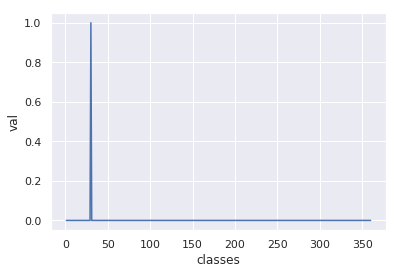

In [15]:
d = {'classes': CATEGORIES_INT, 'val': prediction[0]}
pdnumval = pd.DataFrame(d)
sns.set(style='darkgrid')
sns.lineplot(x='classes', y='val', data=pdnumval)